### Import Library

In [12]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


### Load Preprocessed Data

In [13]:
# 파일 호출
data_path: str =  os.path.join(os.path.dirname(os.path.abspath('')), 'data', 'preprocessed')
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train_df.csv"), index_col=0)
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test_df.csv"), index_col=0)
all_df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

### Make Train, Test Data

In [14]:
train_X = train_df.drop(columns=['target', 'close_price'])
train_y = train_df['target']
train_y_price = train_df['close_price']
test_X = test_df.drop(columns=['target', 'close_price'])

### Load Model

In [15]:
project_path: str = os.path.dirname(os.path.abspath(''))
model_path: str = os.path.join(project_path, 'models')
if project_path not in sys.path:
    sys.path.append(project_path)
if model_path not in sys.path:
    sys.path.append(model_path)
from models.soft_labeling_model import SoftLabelingModel
from models.regression_model import RegressionModel
from models.model import Model

### Validation Process

In [16]:
def get_avg_direction_accuracy(model_class: Model, params: dict, folds: int) -> float:
    accuracy_list = []
    kfold = KFold(n_splits=folds, shuffle=False)
    for train_index, val_index in kfold.split(train_X):
        cur_train_X = train_X.iloc[train_index].copy()
        cur_train_y = train_y.iloc[train_index].copy()
        cur_train_y_price = train_y_price.iloc[train_index].copy()
        cur_val_X = train_X.iloc[val_index].copy()
        cur_val_y = train_y.iloc[val_index].copy()

        model = model_class(**params)
        model.fit(cur_train_X, cur_train_y, cur_train_y_price)
        cur_val_y_pred = model.predict(cur_val_X)

        cur_val_y_direction_pred = cur_val_y_pred.apply(lambda x: 0 if x == 0 or x == 1 else 1)
        cur_val_y_direction = cur_val_y.apply(lambda x: 0 if x == 0 or x == 1 else 1)
        direction_accuracy = accuracy_score(cur_val_y_direction, cur_val_y_direction_pred)
        accuracy_list.append(direction_accuracy)
    return np.mean(accuracy_list)

In [17]:
base_features = ['coinbase_premium_gap', 'funding_rates', 'long_liquidations', 'short_liquidations', 
                    'open_interest', 'buy_ratio', 'buy_sell_ratio', 'buy_volume', 'sell_ratio', 'sell_volume',
                    'active_count', 'receiver_count', 'sender_count', 'block_interval', 'block_count', 'block_bytes', 
                    'blockreward', 'transaction_count', 'token_transferred', 'token_transferred_mean', 
                    'token_transferred_median', 'hashrate', 'difficulty', 'fees_transaction', 'fees', 
                    'velocity_supply', 'utxo_count', 'supply_total', 'supply_new', 'fees_block_mean', 
                    'fees_transaction_median']
diff_features = [feature + '_diff' for feature in base_features]
selected_features = base_features + diff_features

model_params = {
    'learning_rate': 0.1,
    'num_leaves': 10,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
    'max_depth': 4,
    'extra_trees': True,
    'path_smooth': 0.5,
    'random_state': 42,
    'verbose': -1, 
}

In [18]:
reg_result = get_avg_direction_accuracy(RegressionModel, {'model_params': model_params, 'ignore_strength': True}, 4)
print(f"Regression Model: {reg_result}")

Regression Model: 0.5189497716894977


In [29]:
extreme_smoothing_result = get_avg_direction_accuracy(SoftLabelingModel, {'model_params': model_params, 'smoothness': 100000}, 4)
print(f"Extreme Smoothing Model: {extreme_smoothing_result}")

Extreme Smoothing Model: 0.5488584474885845


In [19]:
smoothness_list = [0.1 * i for i in range(1, 500)]
result_list = []
for cur_smoothness in smoothness_list:
    result = get_avg_direction_accuracy(SoftLabelingModel, {'model_params': model_params, 'smoothness': cur_smoothness}, 4)
    result_list.append(result)

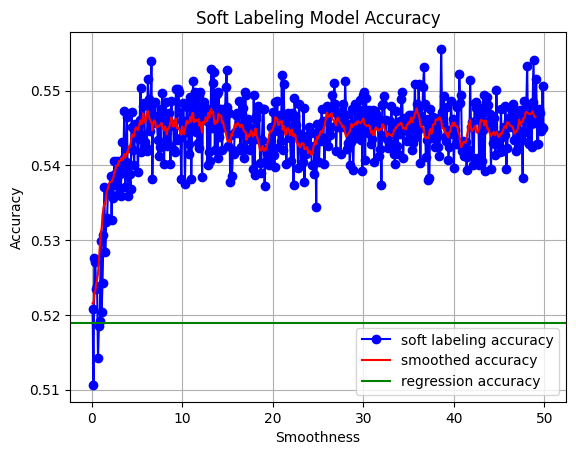

In [30]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 10
smoothed_result = moving_average(result_list, window_size)

plt.plot(smoothness_list, result_list, marker='o', linestyle='-', color='b', label='soft labeling accuracy')
plt.plot(smoothness_list[:len(smoothed_result)], smoothed_result, linestyle='-', color='r', label='smoothed accuracy')
plt.axhline(reg_result, color='green', linestyle='-', label='regression accuracy')

plt.xlabel('Smoothness')
plt.ylabel('Accuracy')
plt.title('Soft Labeling Model Accuracy')
plt.grid(True)
plt.legend()
plt.show()